In [1]:
import os

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from ElexonDataPortal import api

/Users/alanclark/.pyenv/versions/mlpw/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Elexon Data Portal

Examples of accessing [BMRS](https://www.bmreports.com/bmrs/) data using the third-party [Elexon Data Portal python library](https://github.com/OSUKED/ElexonDataPortal).

## Get API key

Obtain Elexon API key from environment variable `ELEXON_API_KEY`. Ensure this is not committed to the repo.

In [2]:
elexon_api_key = os.environ['ELEXON_API_KEY']

## Create a Client

In [3]:
client = api.Client(elexon_api_key)

## Documentation Example

The following example is given in the Elexon Data Portal documentation GitHub. Data being retrieved: Actual Generation Output per Generation Unit.

In [4]:
start_date = '2020-01-01 00:00'
end_date = '2020-01-01 00:30'

In [5]:
df_B1610 = client.get_B1610(start_date, end_date)

B1610: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


In [6]:
df_B1610.head(3)

,local_datetime,documentType,businessType,processType,timeSeriesID,curveType,settlementDate,powerSystemResourceType,registeredResourceEICCode,marketGenerationUnitEICCode,...,bMUnitID,nGCBMUnitID,activeFlag,documentID,documentRevNum,resolution,start,end,settlementPeriod,quantity
0,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-244,Sequential fixed size block,2020-01-01,Generation,48W00000DDGNO-1E,48W00000DDGNO-1E,...,T_DDGNO-1,DDGNO-1,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,30.018
1,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-360,Sequential fixed size block,2020-01-01,Generation,48W000000TORN-2E,48W000000TORN-2E,...,T_TORN-2,TORN-2,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,630.592
2,2020-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-323,Sequential fixed size block,2020-01-01,Generation,48W00000MKHLW-1D,48W00000MKHLW-1D,...,T_MKHLW-1,MKHLW-1,Y,ELX-EMFIP-AGOG-22495386,1,PT30M,2020-01-01,2020-01-01,1,5.342


## Actual Aggregated Generation perType

Extracting [Actual Aggregated Generation perType](https://www.bmreports.com/bmrs/?q=actgenration/actualaggregated).

### Set date range

Looking at the first week of December 2021.

In [7]:
start_date = '2021-12-01 00:00'
end_date = '2021-12-07 00:00'

### Request data

In [8]:
df_B1620 = client.get_B1620(start_date, end_date)

B1620: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:38<00:00,  7.50it/s]


### Necessary Processing

TODO: This will need to be turned into a function.

In [9]:
df_B1620["powerSystemResourceType"] = df_B1620["powerSystemResourceType"].replace(
    to_replace=r'"', value='', regex=True
)
df_B1620["quantity"] = df_B1620["quantity"].astype(float)
df_B1620.set_index('local_datetime', inplace=True)

### Data Investigation

In [10]:
df_B1620.columns

Index(['documentType', 'businessType', 'processType', 'timeSeriesID',
       'quantity', 'curveType', 'resolution', 'settlementDate',
       'settlementPeriod', 'powerSystemResourceType', 'activeFlag',
       'documentID', 'documentRevNum'],
      dtype='object')

In [11]:
df_B1620["powerSystemResourceType"].unique()

array(['Solar', 'Wind Offshore', 'Wind Onshore', 'Other', 'Nuclear',
       'Fossil Oil', 'Fossil Gas', 'Fossil Hard coal',
       'Hydro Run-of-river and poundage', 'Hydro Pumped Storage',
       'Biomass'], dtype=object)

TODO: Implement check which ensures that no other values are found in these columns.

In [12]:
df_B1620[["documentType", "businessType", "processType", "curveType", "resolution", "activeFlag", "documentRevNum"]].drop_duplicates()

,documentType,businessType,processType,curveType,resolution,activeFlag,documentRevNum
local_datetime,,,,,,,
2021-12-01 00:00:00+00:00,Actual generation per type,Solar generation,Realised,Sequential fixed size block,PT30M,Y,1
2021-12-01 00:00:00+00:00,Actual generation per type,Wind generation,Realised,Sequential fixed size block,PT30M,Y,1
2021-12-01 00:00:00+00:00,Actual generation per type,Production,Realised,Sequential fixed size block,PT30M,Y,1


In [13]:
df_B1620.loc[df_B1620["powerSystemResourceType"] == 'Fossil Gas']

,documentType,businessType,processType,timeSeriesID,quantity,curveType,resolution,settlementDate,settlementPeriod,powerSystemResourceType,activeFlag,documentID,documentRevNum
local_datetime,,,,,,,,,,,,,
2021-12-01 00:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887942,2397.0,Sequential fixed size block,PT30M,2021-12-01,1,Fossil Gas,Y,NGET-EMFIP-AGPT-06397371,1
2021-12-01 00:30:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887953,2416.0,Sequential fixed size block,PT30M,2021-12-01,2,Fossil Gas,Y,NGET-EMFIP-AGPT-06397372,1
2021-12-01 01:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887964,2421.0,Sequential fixed size block,PT30M,2021-12-01,3,Fossil Gas,Y,NGET-EMFIP-AGPT-06397373,1
2021-12-01 01:30:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887975,2316.0,Sequential fixed size block,PT30M,2021-12-01,4,Fossil Gas,Y,NGET-EMFIP-AGPT-06397374,1
2021-12-01 02:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887986,2407.0,Sequential fixed size block,PT30M,2021-12-01,5,Fossil Gas,Y,NGET-EMFIP-AGPT-06397375,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06 21:30:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21891055,13482.0,Sequential fixed size block,PT30M,2021-12-06,44,Fossil Gas,Y,NGET-EMFIP-AGPT-06397654,1
2021-12-06 22:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21891066,11352.0,Sequential fixed size block,PT30M,2021-12-06,45,Fossil Gas,Y,NGET-EMFIP-AGPT-06397655,1
2021-12-06 22:30:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21891077,9347.0,Sequential fixed size block,PT30M,2021-12-06,46,Fossil Gas,Y,NGET-EMFIP-AGPT-06397656,1


### Visualisation

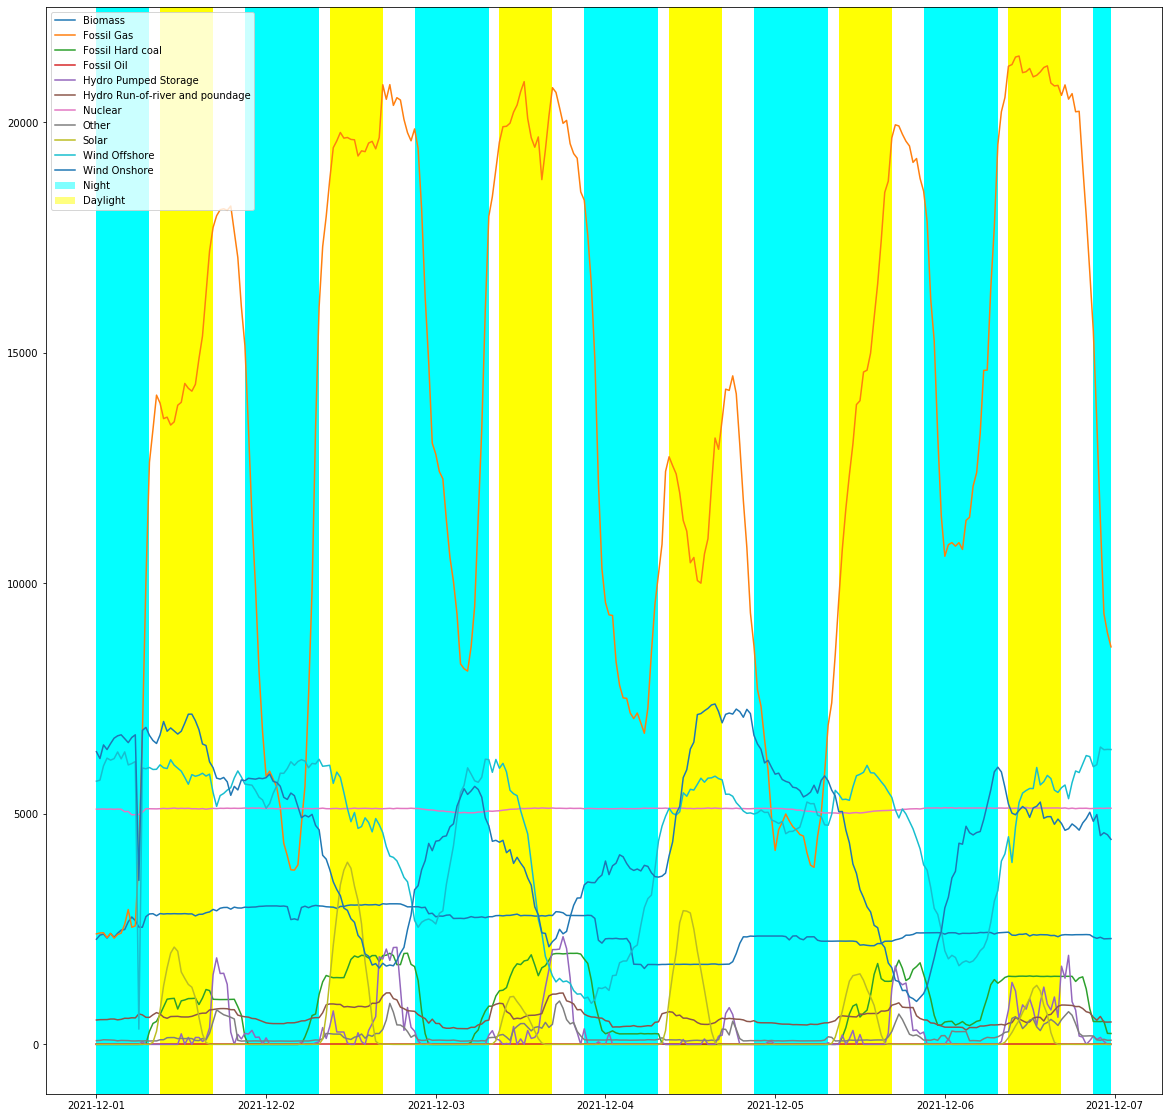

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
legend_labels = []

for gen_type, gen_df in df_B1620.groupby("powerSystemResourceType"):
    # gen_df = df_B1620.loc[df_B1620["powerSystemResourceType"] == gen_type, 'quantity']
    ax.plot(
        gen_df['quantity'],
        ls='-',
    )
    legend_labels.append(gen_type)

sunrise = 9
sunset = 16

core_day_start_hr = 7
core_day_end_hr = 21

for d in np.unique(df_B1620.index.date):
    core_day_start = datetime.datetime(d.year, d.month, d.day, core_day_start_hr)
    core_day_end = datetime.datetime(d.year, d.month, d.day, core_day_end_hr)

    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    core_day_mask = (gen_df.index.hour >= core_day_end_hr) | (gen_df.index.hour <= core_day_start_hr)
    ax.fill_between(
        gen_df.index, 0, 1, where=core_day_mask, facecolor='cyan', alpha=0.5, transform=trans,
    )
    
    sunshine_mask = (gen_df.index.hour >= sunrise) & (gen_df.index.hour <= sunset)
    ax.fill_between(
        gen_df.index, 0, 1, where=sunshine_mask, facecolor='yellow', alpha=0.5, transform=trans,
    )

legend_labels.extend(['Night', 'Daylight'])
ax.legend(legend_labels)